In [ ]:
#%% INSTALL DEPENDENCIES (run once)
!pip install -q torch transformers datasets jiwer librosa psutil matplotlib openai-whisper vosk speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 18.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [ ]:
!sudo apt update > /dev/null 2>&1 && sudo apt upgrade > /dev/null 2>&1 -y
!sudo apt install ffmpeg > /dev/null 2>&1

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Changing to the project firectory
%cd /content/drive/MyDrive/EXA
%ls

In [ ]:
# # If Necessary
# !ffmpeg -i audio.waptt audio.wav

In [ ]:
# !pip install huggingsound

In [ ]:
# Enabling Hugging Face Token Id
!pip install huggingface-hub
!huggingface-cli login

In [ ]:
#%% IMPORTS
import os
import time
import json
import psutil
import numpy as np
import librosa
import matplotlib.pyplot as plt
from jiwer import wer, cer
from collections import defaultdict

#%% HELPER FUNCTIONS
def load_audio(audio_path, target_sr=16000):
    """Load audio and resample to target sample rate."""
    audio, sr = librosa.load(audio_path, sr=target_sr, mono=True)
    return audio, sr

def float_to_pcm16(audio):
    """Convert floating-point audio (range -1 to 1) to PCM 16-bit integer format."""
    return (audio * 32767).astype(np.int16)

def print_metrics(metrics_dict):
    """Print formatted metrics."""
    print(f"WER: {metrics_dict['wer']:.2%}")
    print(f"CER: {metrics_dict['cer']:.2%}")
    print(f"Inference Time: {metrics_dict['inference_time']:.2f}s")
    print(f"Memory Usage: {metrics_dict['memory_usage']:.2f}MB")
    print(f"CPU Usage: {metrics_dict['cpu_usage']:.2f}%")

output = ''

with open('output.txt', 'r', encoding='utf-8') as file:
    output = file.read()

#%% CONFIGURATION
AUDIO_PATH = "audio.wav"  # Replace with your audio file path
REFERENCE_TEXT = output  # Replace with the ground truth text

#%% Initialize results storage
results = defaultdict(dict)

In [ ]:
# output

In [ ]:
#%% ==================== WHISPER ====================
def evaluate_whisper(model='large'):
    import whisper

    start_mem = psutil.virtual_memory().used
    start_cpu = psutil.cpu_percent(interval=None)
    start_time = time.time()

    model = whisper.load_model(model)
    result = model.transcribe(AUDIO_PATH, language="pt")

    metrics = {
        'wer': wer(REFERENCE_TEXT, result['text']),
        'cer': cer(REFERENCE_TEXT, result['text']),
        'inference_time': time.time() - start_time,
        'memory_usage': (psutil.virtual_memory().used - start_mem) / 1024**2,
        'cpu_usage': psutil.cpu_percent(interval=None) - start_cpu
    }

    results['Whisper'] = metrics
    print("Whisper Metrics:")
    print_metrics(metrics)
    print('\nTranscribed:\n', result['text'])

evaluate_whisper()

100%|█████████████████████████████████████| 2.88G/2.88G [11:24<00:00, 4.51MiB/s]
/Users/lucas/miniconda3/envs/exa/lib/python3.11/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Whisper Metrics:
WER: 5.66%
CER: 2.75%
Inference Time: 732.81s
Memory Usage: -181.48MB
CPU Usage: -23.90%

Transcribed:
  Olá, gente. Este aqui é um áudio teste para a galera do WhatsApp. Barella, por favor, baixe esse áudio e aí você joga nos momentos do áudio para a gente poder carregar, né? Aí nomeia ele como você quiser. Mas, enfim, esse aqui é um áudio bem básico, né, gente? Porém, a gente aqui vai estar nesse projeto de criar um chatbot do WhatsApp em que a gente vai poder ler textos, áudios, localização, imagens do QR Code. E até agora, acho que é isso que a gente está. Eu estou aqui na salinha da ESA, do laboratório aqui da PUC e estamos juntos.


In [ ]:
#%% ==================== WAV2VEC2 XLSR-53 ====================
def evaluate_wav2vec2():
    from transformers import Wav2Vec2ForCTC, AutoProcessor
    import torch

    audio, sr = load_audio(AUDIO_PATH)

    start_mem = psutil.virtual_memory().used
    start_cpu = psutil.cpu_percent(interval=None)
    start_time = time.time()

    processor = AutoProcessor.from_pretrained("facebook/wav2vec2-large-xlsr-53-portuguese")
    model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-portuguese")

    inputs = processor(audio, sampling_rate=sr, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]

    metrics = {
        'wer': wer(REFERENCE_TEXT, transcription),
        'cer': cer(REFERENCE_TEXT, transcription),
        'inference_time': time.time() - start_time,
        'memory_usage': (psutil.virtual_memory().used - start_mem) / 1024**2,
        'cpu_usage': psutil.cpu_percent(interval=None) - start_cpu
    }

    results['Wav2Vec2-XLSR'] = metrics
    print("Wav2Vec2 Metrics:")
    print_metrics(metrics)
    print('\nTranscribed Text:', transcription)

# evaluate_wav2vec2()

In [ ]:
# Evaluating Grosman Portuguese Model (Wav2Vec2 Fine tunning)
#%% ==================== WAV2VEC2 XLSR-53 ====================
def evaluate_wav2vec2_grosman():
    from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
    import torch

    MODEL_ID = "jonatasgrosman/wav2vec2-large-xlsr-53-portuguese"

    audio, sr = load_audio(AUDIO_PATH)

    start_mem = psutil.virtual_memory().used
    start_cpu = psutil.cpu_percent(interval=None)
    start_time = time.time()

    processor = Wav2Vec2Processor.from_pretrained(MODEL_ID)
    model = Wav2Vec2ForCTC.from_pretrained(MODEL_ID)

    inputs = processor(audio, sampling_rate=sr, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]

    metrics = {
        'wer': wer(REFERENCE_TEXT, transcription),
        'cer': cer(REFERENCE_TEXT, transcription),
        'inference_time': time.time() - start_time,
        'memory_usage': (psutil.virtual_memory().used - start_mem) / 1024**2,
        'cpu_usage': psutil.cpu_percent(interval=None) - start_cpu
    }

    results['Wav2Vec2-XLSR'] = metrics
    print("Wav2Vec2 Grosman Metrics:")
    print_metrics(metrics)
    print('\nTranscribed Text:', transcription)

# evaluate_wav2vec2_grosman()

In [ ]:
# If needed

# !wget -c "https://alphacephei.com/vosk/models/vosk-model-pt-fb-v0.1.1-20220516_2113.zip"
# !unzip "vosk-model-pt-fb-v0.1.1-20220516_2113.zip"
# !pwd
# !ls

--2025-02-06 21:40:47--  https://alphacephei.com/vosk/models/vosk-model-pt-fb-v0.1.1-20220516_2113.zip
Resolving alphacephei.com (alphacephei.com)... 188.40.21.16, 2a01:4f8:13a:279f::2
Connecting to alphacephei.com (alphacephei.com)|188.40.21.16|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  vosk-model-pt-fb-v0.1.1-20220516_2113.zip
   creating: vosk-model-pt-fb-v0.1.1-20220516_2113/
   creating: vosk-model-pt-fb-v0.1.1-20220516_2113/ivector/
  inflating: vosk-model-pt-fb-v0.1.1-20220516_2113/ivector/splice_opts  
  inflating: vosk-model-pt-fb-v0.1.1-20220516_2113/ivector/splice.conf  
  inflating: vosk-model-pt-fb-v0.1.1-20220516_2113/ivector/global_cmvn.stats  
  inflating: vosk-model-pt-fb-v0.1.1-20220516_2113/ivector/final.mat  
  inflating: vosk-model-pt-fb-v0.1.1-20220516_2113/ivector/online_cmvn.conf  
  inflating: vosk-model-pt-fb-v0.1.1-20220516_2113/ivector/fina

In [ ]:
# !vosk-transcriber -i audio.wav -l pt -n vosk-model-pt-fb-v0.1.1-20220516_2113

In [ ]:
#%% ==================== VOSK ====================
def evaluate_vosk():
    from vosk import Model, KaldiRecognizer

    audio, sr = load_audio(AUDIO_PATH)
    # Convert to 16-bit PCM as required by Vosk
    pcm_audio = float_to_pcm16(audio)

    start_mem = psutil.virtual_memory().used
    start_cpu = psutil.cpu_percent(interval=None)
    start_time = time.time()

    model_path = "vosk-model-pt-fb-v0.1.1-20220516_2113"
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model directory not found: {model_path}")
    if not os.path.isdir(model_path):
        raise NotADirectoryError(f"Model path is not a directory: {model_path}")

    model = Model(model_path)  # Ensure this model is downloaded and available locally
    recognizer = KaldiRecognizer(model, sr)

    recognizer.AcceptWaveform(pcm_audio.tobytes())
    result_json = json.loads(recognizer.FinalResult())
    transcription = result_json.get("text", "")

    metrics = {
        'wer': wer(REFERENCE_TEXT, transcription),
        'cer': cer(REFERENCE_TEXT, transcription),
        'inference_time': time.time() - start_time,
        'memory_usage': (psutil.virtual_memory().used - start_mem) / 1024**2,
        'cpu_usage': psutil.cpu_percent(interval=None) - start_cpu
    }

    results['Vosk'] = metrics
    print("Vosk Metrics:")
    print_metrics(metrics)
    print('\nTranscribed Text:', transcription)

# evaluate_vosk()

In [ ]:
#%% ==================== NVIDIA NEMO ====================
def evaluate_nemo():
    import nemo.collections.asr as nemo_asr
    import nemo.collections.asr as nemo_asr


    start_mem = psutil.virtual_memory().used
    start_cpu = psutil.cpu_percent(interval=None)
    start_time = time.time()

    model = nemo_asr.models.EncDecHybridRNNTCTCBPEModel.from_pretrained(model_name="nvidia/stt_pt_fastconformer_hybrid_large_pc")
    transcription = model.transcribe([AUDIO_PATH])[0]

    metrics = {
        'wer': wer(REFERENCE_TEXT, transcription),
        'cer': cer(REFERENCE_TEXT, transcription),
        'inference_time': time.time() - start_time,
        'memory_usage': (psutil.virtual_memory().used - start_mem) / 1024**2,
        'cpu_usage': psutil.cpu_percent(interval=None) - start_cpu
    }

    results['NVIDIA-NeMo'] = metrics
    print("NeMo Metrics:")
    print_metrics(metrics)
    print('\nTranscribed Text:', transcription)

evaluate_nemo()

In [ ]:
def evaluate_nemo():
    import nemo.collections.asr as nemo_asr
    import psutil
    import time
    import torch

    # Track memory and CPU usage
    start_mem = psutil.virtual_memory().used
    start_cpu = psutil.cpu_percent(interval=None)
    start_time = time.time()

    # Load the pre-trained Portuguese ASR model
    model = nemo_asr.models.EncDecHybridRNNTCTCBPEModel.from_pretrained(
        model_name="nvidia/stt_pt_fastconformer_hybrid_large_pc"
    )

    # Ensure the model is moved to the appropriate device (GPU or CPU)
    if torch.cuda.is_available():
        model.to('cuda')
    else:
        model.to('cpu')

    # Transcribe the audio file
    try:
        transcription = model.transcribe([AUDIO_PATH], batch_size=4)[0]  # Reduce batch size if needed
    except RuntimeError as e:
        print("Error during transcription:", e)
        return

    # Calculate metrics
    metrics = {
        'wer': wer(REFERENCE_TEXT, transcription),
        'cer': cer(REFERENCE_TEXT, transcription),
        'inference_time': time.time() - start_time,
        'memory_usage': (psutil.virtual_memory().used - start_mem) / 1024**2,
        'cpu_usage': psutil.cpu_percent(interval=None) - start_cpu
    }

    # Store results and print metrics
    results['NVIDIA-NeMo'] = metrics
    print("NeMo Metrics:")
    print_metrics(metrics)
    print('\nTranscribed Text:', transcription)

# evaluate_nemo()

In [ ]:
# #%% ==================== COQUI STT ====================
# def evaluate_coqui():
#     from stt import Model

#     audio, sr = load_audio(AUDIO_PATH)
#     # Convert to 16-bit PCM if required by Coqui STT
#     pcm_audio = float_to_pcm16(audio)

#     start_mem = psutil.virtual_memory().used
#     start_cpu = psutil.cpu_percent(interval=None)
#     start_time = time.time()

#     model = Model("coqui-stt-1.2.0-portuguese.pbmm")  # Ensure this model is downloaded and available locally
#     transcription = model.stt(pcm_audio)

#     metrics = {
#         'wer': wer(REFERENCE_TEXT, transcription),
#         'cer': cer(REFERENCE_TEXT, transcription),
#         'inference_time': time.time() - start_time,
#         'memory_usage': (psutil.virtual_memory().used - start_mem) / 1024**2,
#         'cpu_usage': psutil.cpu_percent(interval=None) - start_cpu
#     }

#     results['Coqui-STT'] = metrics
#     print("Coqui Metrics:")
#     print_metrics(metrics)

In [ ]:
#%% ==================== SPEECHBRAIN ====================
def evaluate_speechbrain():
    from speechbrain.pretrained import EncoderDecoderASR
    from speechbrain.inference.ASR import EncoderASR

    start_mem = psutil.virtual_memory().used
    start_cpu = psutil.cpu_percent(interval=None)
    start_time = time.time()

    model = EncoderASR.from_hparams(
        source="speechbrain/asr-wav2vec2-commonvoice-14-pt",
        savedir="pretrained_models/asr-wav2vec2-commonvoice-14-pt"
    )
    transcription = model.transcribe_file(AUDIO_PATH)

    metrics = {
        'wer': wer(REFERENCE_TEXT, transcription),
        'cer': cer(REFERENCE_TEXT, transcription),
        'inference_time': time.time() - start_time,
        'memory_usage': (psutil.virtual_memory().used - start_mem) / 1024**2,
        'cpu_usage': psutil.cpu_percent(interval=None) - start_cpu
    }

    results['SpeechBrain'] = metrics
    print("SpeechBrain Metrics:")
    print_metrics(metrics)
    print('\nTranscribed Text:', transcription)

# evaluate_speechbrain()

In [ ]:
#%% ==================== RUN ALL EVALUATIONS ====================

evaluate_functions = [
        evaluate_whisper,
        evaluate_wav2vec2,
        evaluate_vosk,
        evaluate_nemo,
        # evaluate_coqui,
        evaluate_speechbrain
    ]

# if __name__ == "__main__":

#     for func in evaluate_functions:
#         try:
#             func()
#         except Exception as e:
#             print(f"Error in {func.__name__}: {str(e)}")

# In a notebook, __name__ is not '__main__', so run evaluations manually as well
for func in evaluate_functions:
    try:
        func()
    except Exception as e:
        print(f"Error in {func.__name__}: {str(e)}")

100%|█████████████████████████████████████| 2.88G/2.88G [00:38<00:00, 80.9MiB/s]
/usr/local/lib/python3.11/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

Whisper Metrics:
WER: 5.66%
CER: 2.75%
Inference Time: 261.72s
Memory Usage: 6889.98MB
CPU Usage: 3.10%

Transcribed:
  Olá, gente. Este aqui é um áudio teste para a galera do WhatsApp. Barella, por favor, baixe esse áudio e aí você joga nos momentos do áudio para a gente poder carregar, né? Aí nomeia ele como você quiser. Mas, enfim, esse aqui é um áudio bem básico, né, gente? Porém, a gente aqui vai estar nesse projeto de criar um chatbot do WhatsApp em que a gente vai poder ler textos, áudios, localização, imagens do QR Code. E até agora, acho que é isso que a gente está. Eu estou aqui na salinha da ESA, do laboratório aqui da PUC e estamos juntos.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Wav2Vec2 Metrics:
WER: 82.08%
CER: 37.43%
Inference Time: 65.21s
Memory Usage: 68.50MB
CPU Usage: 5.30%

Transcribed Text: quada a gente este qui ao maudio taiste par a glalera do gatsape  ebarella por favô mbaixo e ciaudio e ahi você joga e nos momentos dia doale pra mintipode carregar neai nomeia illhe como você quizer mas emfim issa que é um audio bem basico no a gente porém gente aqui batamose proijecto o dia criaum chacbotbatzape em uenjooa poderler trexto s audes lucalização e maigensnendo que a recoude e até agora acoqe a isso quequer enstarao toca nossa linha da essa polaboratório do a que dapudue tao junto
Vosk Metrics:
WER: 76.42%
CER: 41.47%
Inference Time: 76.15s
Memory Usage: 2305.39MB
CPU Usage: -30.00%

Transcribed Text: olá gente quem sequer um áudio desistiu para galera do whatsapp é barela por favor baixe esse áudio que levou jogando nos momentos de dual de princípio de carregar além do médico como você quiser mas enfim isso é alto bem básico né gente porém de shake b

(…)tt_pt_fastconformer_hybrid_large_pc.nemo:   0%|          | 0.00/453M [00:00<?, ?B/s]

[NeMo W 2025-02-07 02:04:05 nemo_logging:405] Skipped conversion for config/subconfig:
    {'manifest_filepath': '???', 'sample_rate': 16000, 'batch_size': 32, 'shuffle': True, 'num_workers': 8, 'pin_memory': True, 'max_duration': 20, 'min_duration': 0.1, 'is_tarred': False, 'tarred_audio_filepaths': None, 'shuffle_n': 2048, 'bucketing_strategy': 'synced_randomized', 'bucketing_batch_size': None}
     Reason: Missing mandatory value: train_ds.manifest_filepath
        full_key: train_ds.manifest_filepath
        object_type=dict.
[NeMo W 2025-02-07 02:04:05 nemo_logging:405] Skipped conversion for config/subconfig:
    {'manifest_filepath': '???', 'sample_rate': 16000, 'batch_size': 32, 'shuffle': False, 'use_start_end_token': False, 'num_workers': 8, 'pin_memory': True}
     Reason: Missing mandatory value: validation_ds.manifest_filepath
        full_key: validation_ds.manifest_filepath
        object_type=dict.
[NeMo W 2025-02-07 02:04:05 nemo_logging:405] Skipped conversion for con

[NeMo I 2025-02-07 02:04:05 nemo_logging:393] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2025-02-07 02:04:05 nemo_logging:405] Skipped conversion for config/subconfig:
    {'manifest_filepath': '???', 'sample_rate': 16000, 'batch_size': 32, 'shuffle': True, 'num_workers': 8, 'pin_memory': True, 'max_duration': 20, 'min_duration': 0.1, 'is_tarred': False, 'tarred_audio_filepaths': None, 'shuffle_n': 2048, 'bucketing_strategy': 'synced_randomized', 'bucketing_batch_size': None}
     Reason: Missing mandatory value: train_ds.manifest_filepath
        full_key: train_ds.manifest_filepath
        object_type=dict.
[NeMo W 2025-02-07 02:04:05 nemo_logging:405] Skipped conversion for config/subconfig:
    {'manifest_filepath': '???', 'sample_rate': 16000, 'batch_size': 32, 'shuffle': False, 'use_start_end_token': False, 'num_workers': 8, 'pin_memory': True}
     Reason: Missing mandatory value: validation_ds.manifest_filepath
        full_key: validation_ds.manifest_filepath
        object_type=dict.
[NeMo W 2025-02-07 02:04:05 nemo_logging:405] Skipped conversion for con

[NeMo I 2025-02-07 02:04:05 nemo_logging:393] PADDING: 0
[NeMo I 2025-02-07 02:04:06 nemo_logging:393] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}
[NeMo I 2025-02-07 02:04:06 nemo_logging:393] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2025-02-07 02:04:06 nemo_logging:405] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: CUDA is not available


[NeMo I 2025-02-07 02:04:07 nemo_logging:393] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2025-02-07 02:04:07 nemo_logging:405] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: CUDA is not available


[NeMo I 2025-02-07 02:04:07 nemo_logging:393] Model EncDecHybridRNNTCTCBPEModel was successfully restored from /root/.cache/huggingface/hub/models--nvidia--stt_pt_fastconformer_hybrid_large_pc/snapshots/036da25fa32e3f11c11105448482845950840685/stt_pt_fastconformer_hybrid_large_pc.nemo.
[NeMo I 2025-02-07 02:04:07 nemo_logging:393] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2025-02-07 02:04:07 nemo_logging:405] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: CUDA is not available
Transcribing: 100%|██████████| 1/1 [00:05<00:00,  5.29s/it]


NeMo Metrics:
WER: 46.23%
CER: 17.98%
Inference Time: 21.13s
Memory Usage: 22.37MB
CPU Usage: -3.80%

Transcribed Text: ['Olá gente, este que é um áudio teste para galhera do WhatsApp Barela, por favor, baixe esse áudio e aí você joga nos momentos de do áudio para gente poder carregar né a nomear ele como você quiser, mas enfim isse que é um áudio bem básico na gente, porém gente aqui vai tar nesse projeto de criar um chatbot do WhatsApp gente vai poder ler textos, áudios, localização, imagens né do Kerricode, e até agora. Acho que isso que que está toqui na salinha da laboratório doqu da Puqu e ttamos junto.']


hyperparams.yaml:   0%|          | 0.00/2.51k [00:00<?, ?B/s]

wav2vec2.ckpt:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

asr.ckpt:   0%|          | 0.00/16.8M [00:00<?, ?B/s]

tokenizer.ckpt:   0%|          | 0.00/253k [00:00<?, ?B/s]

SpeechBrain Metrics:
WER: 80.19%
CER: 38.72%
Inference Time: 127.17s
Memory Usage: 1284.11MB
CPU Usage: -39.00%

Transcribed Text: Olagente esta que umlaudio Telit para a galera do WhatsApp: é barrela, por favor baxaciáudio e a e você joga para? nos momentos deDald-Pícipo de carregarne a enomea ele como você quiser?, mas em fim, isso que é um oude bem base com egente, porja enchequivatanissepro de? cririaa um chahtboto de whatsAppe de Jo pode ler, teest audes localização imagens na dok Aricold? e até agora as queor que te estátoque nossa linha da Esa por laboratório do Akdappogy e? ta junto.


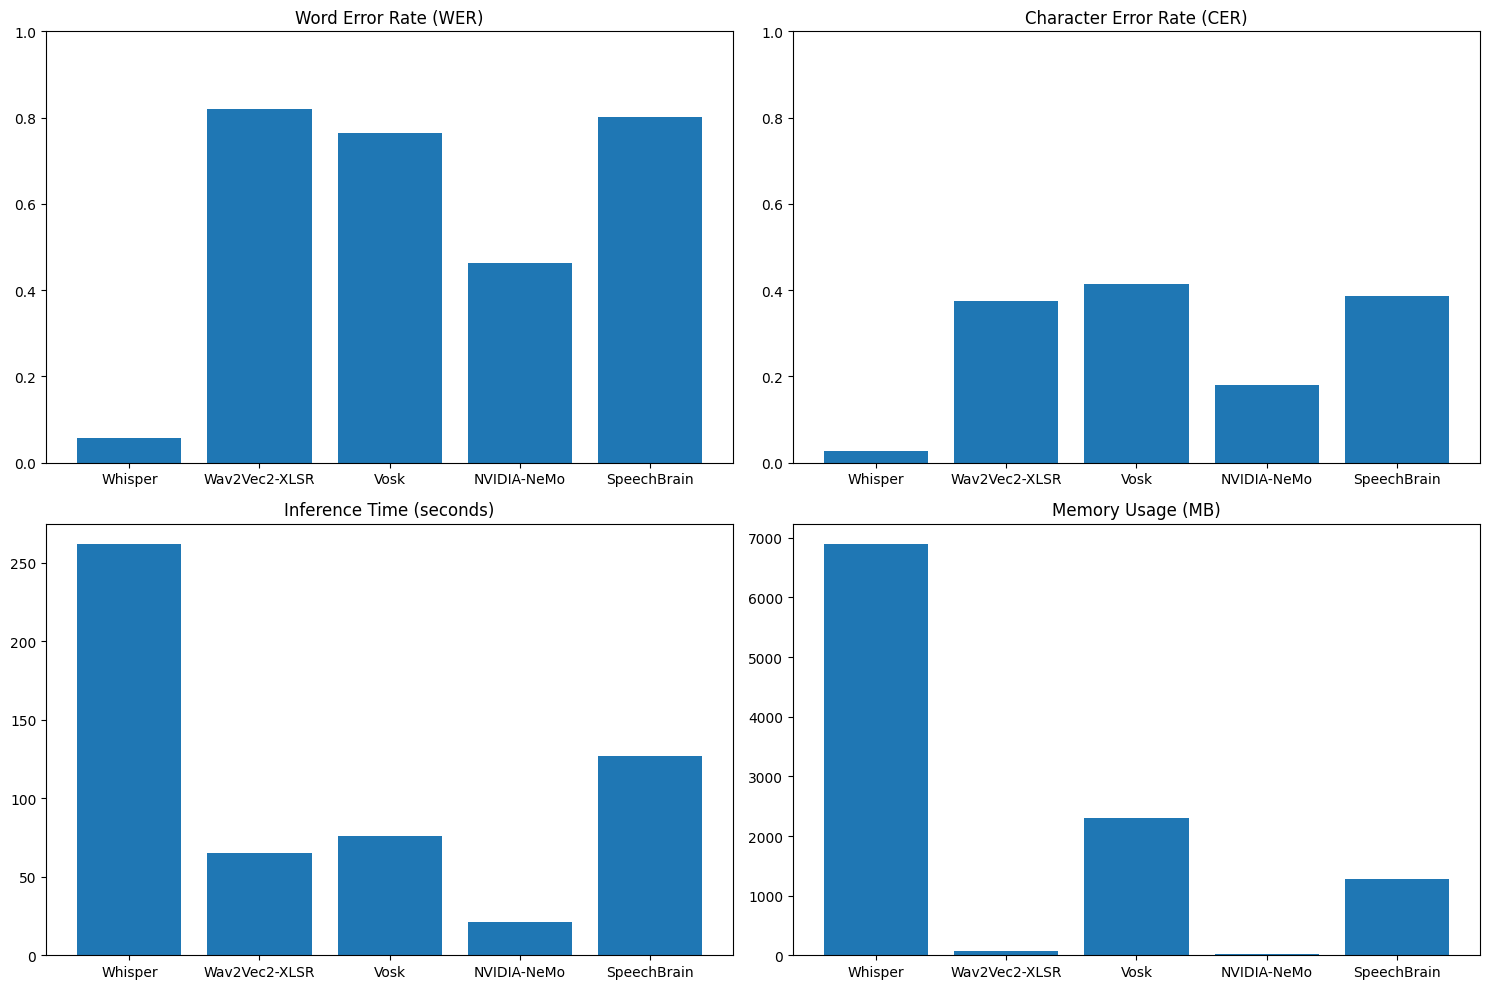

In [ ]:
#%% ==================== PLOT RESULTS ====================
def plot_results():
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # WER Plot
    axs[0,0].bar(results.keys(), [v['wer'] for v in results.values()])
    axs[0,0].set_title('Word Error Rate (WER)')
    axs[0,0].set_ylim(0, 1)

    # CER Plot
    axs[0,1].bar(results.keys(), [v['cer'] for v in results.values()])
    axs[0,1].set_title('Character Error Rate (CER)')
    axs[0,1].set_ylim(0, 1)

    # Inference Time Plot
    axs[1,0].bar(results.keys(), [v['inference_time'] for v in results.values()])
    axs[1,0].set_title('Inference Time (seconds)')

    # Memory Usage Plot
    axs[1,1].bar(results.keys(), [v['memory_usage'] for v in results.values()])
    axs[1,1].set_title('Memory Usage (MB)')

    plt.tight_layout()
    plt.show()

plot_results()

In [ ]:
#%% Initialize results storage
results = defaultdict(dict)

whisper_model_sizes = [
    'tiny',
    'base',
    'small',
    'medium',
    'large',
    'turbo',
    "large-v1",
    "large-v2",
    "large-v3",
    "large",
    "large-v3-turbo"
]

for model in whisper_model_sizes:
    print(f"Evaluating Whisper Model: {model}")
    evaluate_whisper(model)

Evaluating Whisper Model: tiny
Whisper Metrics:
WER: 62.26%
CER: 30.09%
Inference Time: 9.89s
Memory Usage: 92.40MB
CPU Usage: 38.20%

Transcribed:
  Olá gente, esta aqui é um áudio teste para a galera do WhatsApp. É, borela por favor, mais essiálio e aí você joga nos momentos de dual de pra gente poder carregar aí no meio, como você quiser, mas enfim, isso aqui é um áudio bem básico, né gente, porém, de enxaquiva também se projeatude que tem um chat bot do WhatsApp e a gente pode ler. Teste os áudios do carização e mais a gente do que é recolho e até agora acho que é isso que tem a instauta aqui na salinha da eza pela abratoria do aqui da Pooque e estamos juntos.
Evaluating Whisper Model: base
Whisper Metrics:
WER: 42.45%
CER: 18.72%
Inference Time: 12.69s
Memory Usage: 39.23MB
CPU Usage: -32.80%

Transcribed:
  Olá gente, este aqui é um áudio teste para a galera do WhatsApp. Barela, por favor, mais especial de áudio e aí você joga nos momentos de dual de pra gente poder carregar, aí 

100%|█████████████████████████████████████| 1.42G/1.42G [00:28<00:00, 53.3MiB/s]


Whisper Metrics:
WER: 16.98%
CER: 6.24%
Inference Time: 148.91s
Memory Usage: 3666.07MB
CPU Usage: 21.20%

Transcribed:
  Olá gente, este aqui é um áudio teste para a galera do WhatsApp. Barella, por favor, baixe esse áudio e aí você joga nos momentos do áudio para a gente poder carregar, né? Aí nomeia ele como você quiser, mas enfim, isso aqui é um áudio bem básico, né gente? Porém, a gente aqui vai estar nesse projeto de criar um chatbot do WhatsApp, a gente vai poder ler textos, áudios, localização, imagens do QR Code e até agora acho que é isso que a gente está. Eu tô aqui na salinha da ESA, do laboratório aqui da PUC e tamo junto.
Evaluating Whisper Model: large
Whisper Metrics:
WER: 5.66%
CER: 2.75%
Inference Time: 246.53s
Memory Usage: 4684.52MB
CPU Usage: 17.30%

Transcribed:
  Olá, gente. Este aqui é um áudio teste para a galera do WhatsApp. Barella, por favor, baixe esse áudio e aí você joga nos momentos do áudio para a gente poder carregar, né? Aí nomeia ele como você quiser

100%|█████████████████████████████████████| 1.51G/1.51G [01:20<00:00, 20.0MiB/s]


Whisper Metrics:
WER: 7.55%
CER: 3.49%
Inference Time: 200.58s
Memory Usage: 1150.94MB
CPU Usage: 2.00%

Transcribed:
  Olá, gente! Este aqui é um áudio teste para a galera do WhatsApp. Barella, por favor, baixe esse áudio e aí você joga nos momentos do áudio para a gente poder carregar, né? Aí nomear ele como você quiser. Mas, enfim, esse aqui é um áudio bem básico, né, gente? Porém, a gente aqui vai estar nesse projeto de criar um chatbot do WhatsApp e a gente vai poder ler textos, áudios, localização, imagens do QR Code. E até agora, acho que é isso que a gente está. Eu estou aqui na salinha da ESA, do laboratório aqui da PUC e tamo junto.


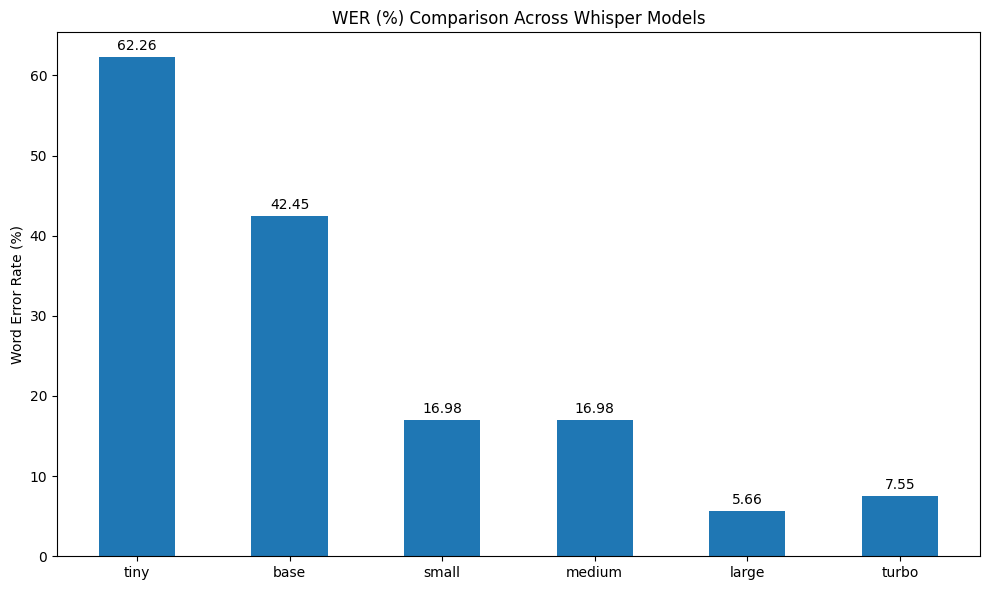

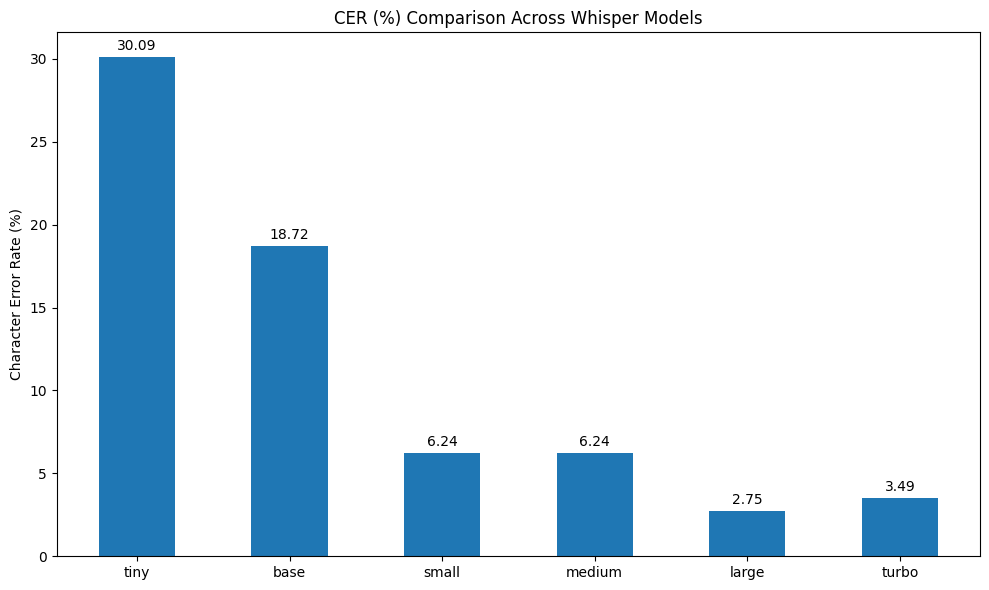

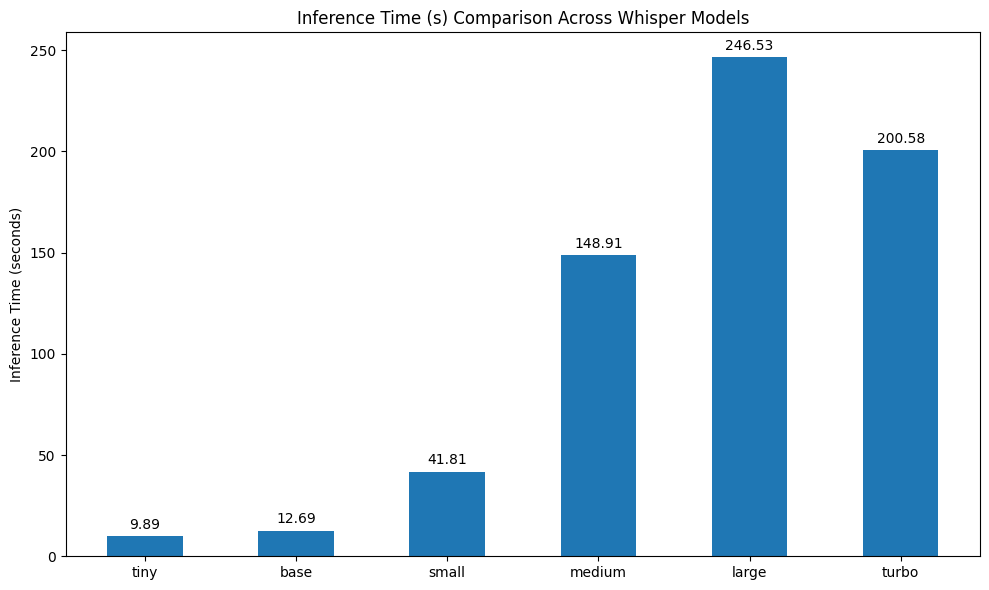

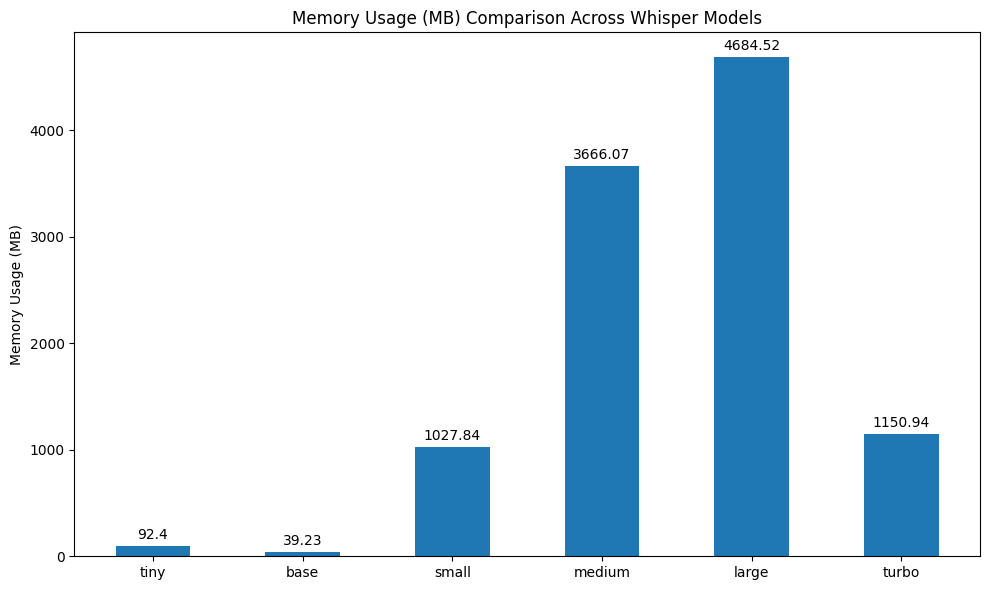

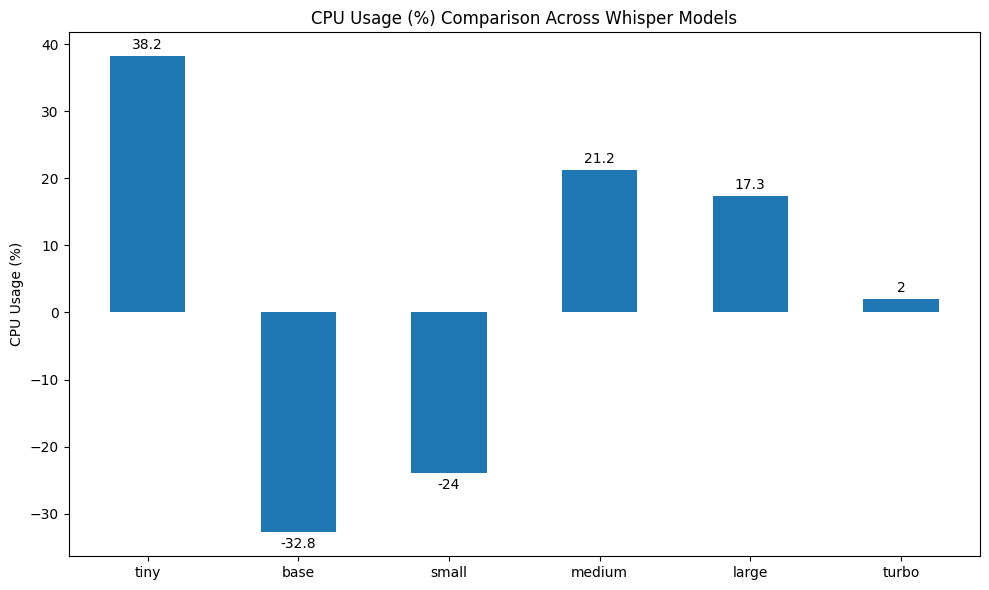

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for each Whisper model
models = ['tiny', 'base', 'small', 'medium', 'large', 'turbo']
wer = [62.26, 42.45, 16.98, 16.98, 5.66, 7.55]
cer = [30.09, 18.72, 6.24, 6.24, 2.75, 3.49]
inference_time = [9.89, 12.69, 41.81, 148.91, 246.53, 200.58]
memory_usage = [92.40, 39.23, 1027.84, 3666.07, 4684.52, 1150.94]
cpu_usage = [38.20, -32.80, -24.00, 21.20, 17.30, 2.00]

# Function to plot bar graphs
def plot_metric(metric_name, values, ylabel):
    x = np.arange(len(models))  # the label locations
    width = 0.5  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(x, values, width, label=metric_name)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(f'{metric_name} Comparison Across Whisper Models')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.bar_label(bars, padding=3)

    fig.tight_layout()
    plt.show()

# Plotting each metric
plot_metric('WER (%)', wer, 'Word Error Rate (%)')
plot_metric('CER (%)', cer, 'Character Error Rate (%)')
plot_metric('Inference Time (s)', inference_time, 'Inference Time (seconds)')
plot_metric('Memory Usage (MB)', memory_usage, 'Memory Usage (MB)')
plot_metric('CPU Usage (%)', cpu_usage, 'CPU Usage (%)')